<a href="https://colab.research.google.com/github/B21-CAP0075/Dementia-Classification/blob/development/Dementia_Care_Logreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import plot_confusion_matrix

import tensorflow as tf

from __future__ import absolute_import, division, print_function
from IPython.display import clear_output
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir /root/.kaggle/
! cp "/content/drive/My Drive/Machine Learning/kaggle.json" /root/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

     |████████████████████████████████| 61kB 7.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=7d385c64f2411556738b7acc540d50edd183f660caff7261d492d57bd4ecb595
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
! kaggle datasets download -d jboysen/mri-and-alzheimers

  0% 0.00/12.6k [00:00<?, ?B/s]
100% 12.6k/12.6k [00:00<00:00, 10.7MB/s]


In [5]:
zip_ref = zipfile.ZipFile('mri-and-alzheimers.zip', 'r')
zip_ref.extractall()
zip_ref.close()

### Cross Sectional Data

In [6]:
df_cross = pd.read_csv('oasis_cross-sectional.csv')
df_cross = df_cross.drop(columns=['ID']) #remove unused column
df_cross = df_cross.drop_duplicates() #remove duplicate
df_cross.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [7]:
df_cross = df_cross.drop(columns=['Delay', 'Hand', 'eTIV', 'nWBV', 'ASF']) #removed bcs user don't have this data
df_cross = df_cross.drop_duplicates()
df_cross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 0 to 415
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     283 non-null    object 
 1   Age     283 non-null    int64  
 2   Educ    231 non-null    float64
 3   SES     212 non-null    float64
 4   MMSE    231 non-null    float64
 5   CDR     231 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 15.5+ KB


In [8]:
for column in df_cross.columns:
    if df_cross[column].dtypes == "object":
        print("Column name: {}".format(column))
        print("Number of unique entry: {}".format(len(df_cross[column].unique())))
        print("Unique entry: {}".format(df_cross[column].unique()))
        print()

print("Column name: {}".format("Educ"))
print("Number of unique entry: {}".format(len(df_cross["Educ"].unique())))
print("Unique entry: {}".format(df_cross["Educ"].unique()))
print()

print("Column name: {}".format("CDR"))
print("Number of unique entry: {}".format(len(df_cross["CDR"].unique())))
print("Unique entry: {}".format(df_cross["CDR"].unique()))
print()

Column name: M/F
Number of unique entry: 2
Unique entry: ['F' 'M']

Column name: Educ
Number of unique entry: 6
Unique entry: [ 2.  4. nan  5.  3.  1.]

Column name: CDR
Number of unique entry: 5
Unique entry: [0.  0.5 nan 1.  2. ]



In [9]:
df_cross.describe()

,Age,Educ,SES,MMSE,CDR
count,283.000000,231.000000,212.000000,231.000000,231.000000
mean,65.318021,3.164502,2.500000,27.021645,0.290043
std,19.081514,1.308416,1.124901,3.714187,0.384861
min,18.000000,1.000000,1.000000,14.000000,0.000000
25%,54.000000,2.000000,2.000000,26.000000,0.000000
50%,71.000000,3.000000,2.000000,29.000000,0.000000
75%,80.000000,4.000000,3.000000,30.000000,0.500000
max,96.000000,5.000000,5.000000,30.000000,2.000000


In [10]:
df_cross["CDR"].value_counts()

0.0    131
0.5     70
1.0     28
2.0      2
Name: CDR, dtype: int64

## Longitudinal Data


In [11]:
df_long = pd.read_csv('oasis_longitudinal.csv')
df_long = df_long.drop(columns=['Subject ID', 'MRI ID']) #remove unused column
df_long.head()

,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [12]:
df_long = df_long.drop(columns=['Visit', 'MR Delay', 'Hand', 'eTIV', 'nWBV', 'ASF', 'Group']) #removed bcs user don't have this data
df_long = df_long.drop_duplicates() #remove duplicate
df_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 0 to 372
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     364 non-null    object 
 1   Age     364 non-null    int64  
 2   EDUC    364 non-null    int64  
 3   SES     345 non-null    float64
 4   MMSE    362 non-null    float64
 5   CDR     364 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 19.9+ KB


In [13]:
for column in df_long.columns:
    if df_long[column].dtypes == "object":
        print("Column name: {}".format(column))
        print("Number of unique entry: {}".format(len(df_long[column].unique())))
        print("Unique entry: {}".format(df_long[column].unique()))
        print()

print("Column name: {}".format("Educ"))
print("Number of unique entry: {}".format(len(df_long["EDUC"].unique())))
print("Unique entry: {}".format(df_long["EDUC"].unique()))
print()

print("Column name: {}".format("CDR"))
print("Number of unique entry: {}".format(len(df_long["CDR"].unique())))
print("Unique entry: {}".format(df_long["CDR"].unique()))
print()

Column name: M/F
Number of unique entry: 2
Unique entry: ['M' 'F']

Column name: Educ
Number of unique entry: 12
Unique entry: [14 12 18 16  8 20 13  6 17 15 23 11]

Column name: CDR
Number of unique entry: 4
Unique entry: [0.  0.5 1.  2. ]



In [14]:
df_long.describe()

,Age,EDUC,SES,MMSE,CDR
count,364.000000,364.000000,345.000000,362.000000,364.000000
mean,77.013736,14.560440,2.478261,27.287293,0.296703
std,7.609428,2.878471,1.138756,3.711225,0.376500
min,60.000000,6.000000,1.000000,4.000000,0.000000
25%,71.750000,12.000000,2.000000,27.000000,0.000000
50%,77.000000,14.000000,2.000000,29.000000,0.000000
75%,82.000000,16.000000,3.000000,30.000000,0.500000
max,98.000000,23.000000,5.000000,30.000000,2.000000


In [15]:
df_long["CDR"].value_counts()

0.0    198
0.5    122
1.0     41
2.0      3
Name: CDR, dtype: int64

## Data Preprocessing


In [16]:
# Converting Longituninal Educ data into Cross-Sectional Educ Data
df_long.loc[df_long.EDUC <= 6, 'EDUC'] =  1
df_long.loc[(df_long.EDUC <= 9) & (df_long.EDUC > 6), 'EDUC'] =  2
df_long.loc[(df_long.EDUC <= 12) & (df_long.EDUC > 9), 'EDUC'] =  3
df_long.loc[(df_long.EDUC <= 16) & (df_long.EDUC > 12), 'EDUC'] =  4
df_long.loc[df_long.EDUC > 16, 'EDUC'] =  5
df_long = df_long.rename(columns = {'EDUC': "Educ"})

print("Unique entry of Educ: {}".format(df_long["Educ"].unique()))

Unique entry of Educ: [4 3 5 2 1]


In [17]:
df_dementia = pd.concat([df_long, df_cross])

df_dementia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 415
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     647 non-null    object 
 1   Age     647 non-null    int64  
 2   Educ    595 non-null    float64
 3   SES     557 non-null    float64
 4   MMSE    593 non-null    float64
 5   CDR     595 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 35.4+ KB


In [18]:
# Change Gender into numerical value

df_dementia["M/F"] = df_dementia["M/F"].apply(lambda x: 1 if x=="M" else 0)

print("Unique entry: {}".format(df_dementia["M/F"].unique()))

Unique entry: [1 0]


In [19]:
#Replace acute dementia with normal dementia

df_dementia['CDR'] = df_dementia['CDR'].replace([.5, 2],[0, 1]) 
df_dementia["CDR"].value_counts()

0.0    521
1.0     74
Name: CDR, dtype: int64

In [20]:
# Handling Missing Values with MICE Algorithm
missing_data= df_dementia[['Age', 'Educ', 'SES', 'MMSE']]

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(missing_data)

df_dementia[['Age', 'Educ', 'SES', 'MMSE']] = np.round(imp.transform(df_dementia[['Age', 'Educ', 'SES', 'MMSE']]))
df_dementia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 415
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     647 non-null    int64  
 1   Age     647 non-null    float64
 2   Educ    647 non-null    float64
 3   SES     647 non-null    float64
 4   MMSE    647 non-null    float64
 5   CDR     595 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 35.4 KB


In [21]:
# Removing Missing value on Output Column
df_dementia = df_dementia.dropna(subset=['CDR'])
df_dementia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595 entries, 0 to 415
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     595 non-null    int64  
 1   Age     595 non-null    float64
 2   Educ    595 non-null    float64
 3   SES     595 non-null    float64
 4   MMSE    595 non-null    float64
 5   CDR     595 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 32.5 KB


## Model w/ Scikit-Learn

In [22]:
dementia_label = df_dementia["CDR"].values
dementia_attributes = df_dementia.drop(columns="CDR").values

X_train_pure, X_test, y_train_pure, y_test = train_test_split(dementia_attributes, dementia_label, test_size=0.2, random_state=29)

lab_enc = preprocessing.LabelEncoder()
y_train_pure = lab_enc.fit_transform(y_train_pure)
y_test = lab_enc.fit_transform(y_test)

print(len(X_train_pure), len(X_test), len(y_train_pure), len(y_test))

pd.DataFrame(y_train_pure).value_counts()
# df_dementia.head()

476 119 476 119


0    418
1     58
dtype: int64

In [23]:
#Oversampling the minority Class

oversampler = RandomOverSampler(sampling_strategy=0.6)

# fit and apply the transform
X_train_over, y_train_over = oversampler.fit_resample(X_train_pure, y_train_pure)

pd.DataFrame(y_train_over, columns=['CDR']).value_counts()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CDR
0      418
1      250
dtype: int64

In [24]:
pd.DataFrame(y_test).value_counts()

0    103
1     16
dtype: int64

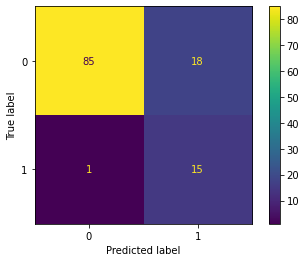

In [25]:
model = LogisticRegression(solver='lbfgs', class_weight='balanced')
model.fit(X_train_over, y_train_over)

pred_test = model.predict(X_test)

#Ploting the confusion matrix
plot_confusion_matrix(model, X_test, y_test)
plt.show()

In [26]:
f1_test = f1_score(pred_test,y_test)
recall_test = recall_score(pred_test,y_test)
prec_test = precision_score(pred_test,y_test)

print("The recall score for the testing data: {}".format(recall_test))
print("The precision score for the testing data: {}".format(prec_test))

print("The f1 score for the testing data: {}".format(f1_test))

The recall score for the testing data: 0.45454545454545453
The precision score for the testing data: 0.9375
The f1 score for the testing data: 0.6122448979591837


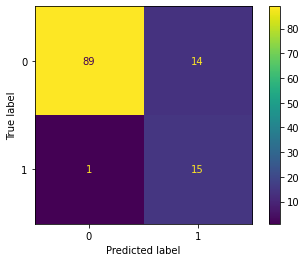

In [27]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear', class_weight='balanced') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train_over, y_train_over)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

#Ploting the confusion matrix
plot_confusion_matrix(clf, X_test, y_test, values_format='d')
plt.show()

In [28]:
f1_test_svm = f1_score(y_pred,y_test)
recall_test_svm = recall_score(y_pred,y_test)
prec_test_svm = precision_score(y_pred,y_test)

print("The recall score for the testing data: {}".format(recall_test_svm))
print("The precision score for the testing data: {}".format(prec_test_svm))

print("The f1 score for the testing data: {}".format(f1_test_svm))

The recall score for the testing data: 0.5172413793103449
The precision score for the testing data: 0.9375
The f1 score for the testing data: 0.6666666666666667


In [29]:
#Undersampling the majority Class

undersampler = RandomUnderSampler()

# fit and apply the transform
X_train_under, y_train_under = undersampler.fit_resample(X_train_pure, y_train_pure)

pd.DataFrame(y_train_under, columns=['CDR']).value_counts()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CDR
1      58
0      58
dtype: int64

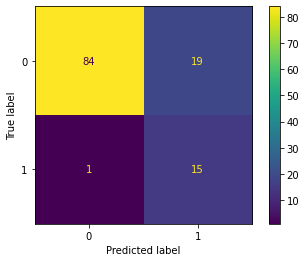

In [30]:
model = LogisticRegression(solver='lbfgs', class_weight='balanced')
model.fit(X_train_under, y_train_under)

pred_test = model.predict(X_test)

#Ploting the confusion matrix
plot_confusion_matrix(model, X_test, y_test)
plt.show()

In [31]:
f1_test = f1_score(pred_test,y_test)
recall_test = recall_score(pred_test,y_test)
prec_test = precision_score(pred_test,y_test)

print("The recall score for the testing data: {}".format(recall_test))
print("The precision score for the testing data: {}".format(prec_test))

print("The f1 score for the testing data: {}".format(f1_test))

The recall score for the testing data: 0.4411764705882353
The precision score for the testing data: 0.9375
The f1 score for the testing data: 0.6


## Model w/ Tensorflow

In [32]:
dfdementia = df_dementia
dfdementia[['Educ','SES']] = dfdementia[['Educ','SES']].astype(int)
dfdementia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595 entries, 0 to 415
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     595 non-null    int64  
 1   Age     595 non-null    float64
 2   Educ    595 non-null    int64  
 3   SES     595 non-null    int64  
 4   MMSE    595 non-null    float64
 5   CDR     595 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 32.5 KB


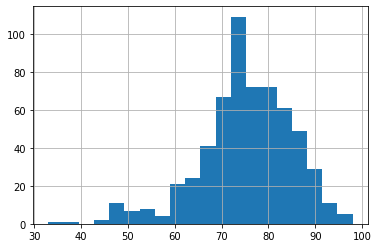

In [33]:
dfdementia.Age.hist(bins=20)

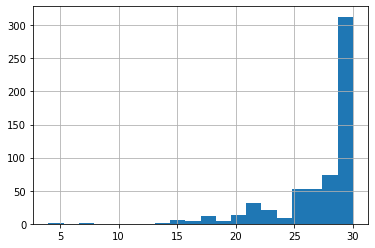

In [34]:
dfdementia.MMSE.hist(bins=20)

Text(0.5, 0, '% dementia')

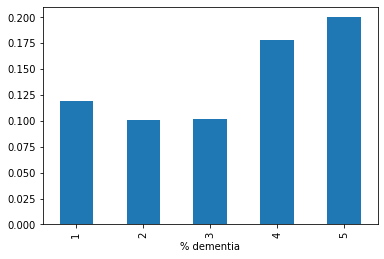

In [35]:
dfdementia.groupby('SES').CDR.mean().plot(kind='bar').set_xlabel('% dementia')

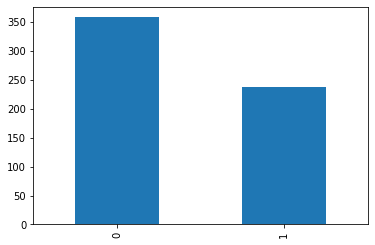

In [36]:
dfdementia['M/F'].value_counts().plot(kind='bar')

Text(0.5, 0, '% dementia')

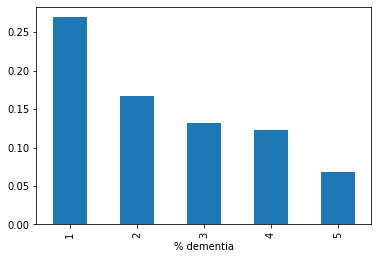

In [37]:
dfdementia.groupby('Educ').CDR.mean().plot(kind='bar').set_xlabel('% dementia')

Text(0.5, 0, '% dementia')

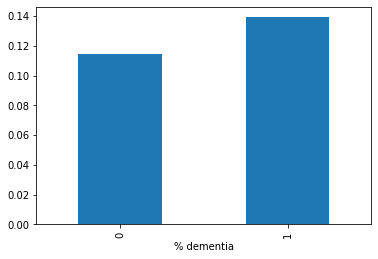

In [38]:
dfdementia.groupby('M/F').CDR.mean().plot(kind='bar').set_xlabel('% dementia')

In [39]:
data_label = dfdementia["CDR"]
data_attributes = dfdementia.drop(columns="CDR")

data_attributes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595 entries, 0 to 415
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     595 non-null    int64  
 1   Age     595 non-null    float64
 2   Educ    595 non-null    int64  
 3   SES     595 non-null    int64  
 4   MMSE    595 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 27.9 KB


In [40]:
#splitting into train and test
dftrain_pure, dftest, yftrain_pure, yftest = train_test_split(data_attributes, data_label, test_size=0.2, random_state=29)

0.0    418
1.0     58
Name: CDR, dtype: int64


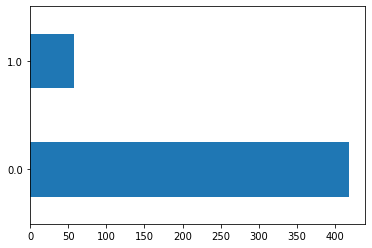

In [41]:
ax = yftrain_pure.value_counts().plot(kind='barh')
print(yftrain_pure.value_counts())

### Oversample the Data

In [42]:
#Oversampling the minority Class

oversampler = RandomOverSampler(sampling_strategy=0.8, random_state=29)

# fit and apply the transform
dftrain_over, yftrain_over = oversampler.fit_resample(dftrain_pure, yftrain_pure)

dftrain_over = pd.DataFrame(dftrain_over, columns=['M/F', 'Age', 'Educ', 'SES', 'MMSE'])
dftrain_over[['M/F','Educ','SES']] = dftrain_over[['M/F','Educ','SES']].astype(int)

yftrain_over = pd.DataFrame(yftrain_over, columns=['CDR'])

pd.concat([dftrain_over, yftrain_over]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1504 entries, 0 to 751
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     752 non-null    float64
 1   Age     752 non-null    float64
 2   Educ    752 non-null    float64
 3   SES     752 non-null    float64
 4   MMSE    752 non-null    float64
 5   CDR     752 non-null    float64
dtypes: float64(6)
memory usage: 82.2 KB


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CDR
0.0    418
1.0    334
dtype: int64


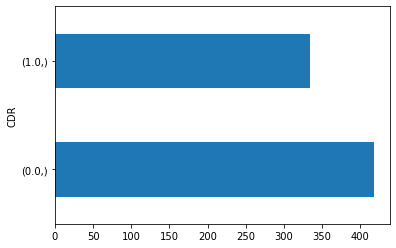

In [43]:
yftrain_over.value_counts().plot(kind='barh')
print(yftrain_over.value_counts())

In [44]:
#Dataset Preparation
CATEGORICAL_COLUMNS = ['M/F', 'SES', 'Educ']
NUMERIC_COLUMNS = ['MMSE', 'Age']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain_over[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

for value in feature_columns:
  if not hasattr(value, 'shape'):
    print("The {} column have {} as unique value with {} data type".format(value.key,value.vocabulary_list, value.dtype))
  else:
    print("The {} column have {} shape with {} data type".format(value.key,value.shape, value.dtype))

The M/F column have (0, 1) as unique value with <dtype: 'int64'> data type
The SES column have (3, 1, 2, 4, 5) as unique value with <dtype: 'int64'> data type
The Educ column have (3, 4, 5, 2, 1) as unique value with <dtype: 'int64'> data type
The MMSE column have (1,) shape with <dtype: 'float32'> data type
The Age column have (1,) shape with <dtype: 'float32'> data type


In [45]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=10):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain_over, yftrain_over)
eval_input_fn = make_input_fn(dftest, yftest, num_epochs=1, shuffle=False)

In [46]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.90756303, 'accuracy_baseline': 0.8655462, 'auc': 0.92718446, 'auc_precision_recall': 0.59450734, 'average_loss': 0.34106165, 'label/mean': 0.13445379, 'loss': 0.3419952, 'precision': 0.6086956, 'prediction/mean': 0.28371817, 'recall': 0.875, 'global_step': 760}


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmptvxd6les/model.ckpt-760
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


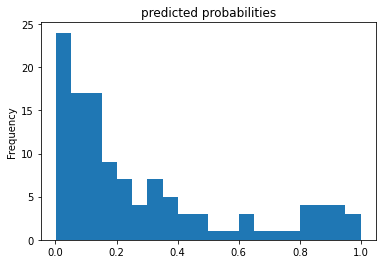

In [47]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0.0, 1.05)

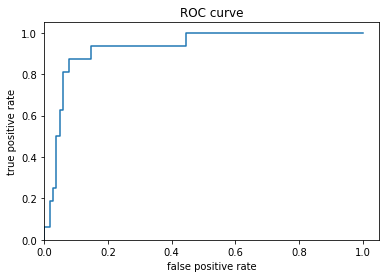

In [48]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(yftest, probs)

plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)

In [49]:
res = pd.Series([pred['class_ids'][0] for pred in pred_dicts])
res

i = 0
false_positive = []
for index,value in enumerate(yftest):
    if (value == 0 and res[i] == 1):
      false_positive.append(index)
      print(probs[i], i)
    i += 1

print()
print(false_positive)
print()

data_fp = dfdementia[dfdementia.index.isin(false_positive)]

print(data_fp)

0.7922684550285339 14
0.6187832951545715 22
0.6073552966117859 42
0.8845605850219727 58
0.8393357992172241 62
0.9745053052902222 69
0.9618729948997498 88
0.9070231318473816 98
0.525502622127533 110

[14, 22, 42, 58, 62, 69, 88, 98, 110]

     M/F   Age  Educ  SES  MMSE  CDR
14     0  95.0     4    2  29.0  0.0
22     0  81.0     3    4  30.0  0.0
42     0  64.0     4    3  29.0  0.0
58     0  88.0     3    3  30.0  0.0
62     0  79.0     4    1  29.0  0.0
69     0  70.0     4    4  30.0  0.0
88     1  68.0     4    4  21.0  1.0
98     1  66.0     4    1  21.0  1.0
110    1  74.0     5    2  29.0  0.0
14     1  82.0     2    4  27.0  0.0
42     1  64.0     2    4  22.0  0.0
62     0  71.0     4    1  27.0  1.0
69     1  43.0     4    2  30.0  0.0
98     0  81.0     2    4  30.0  0.0


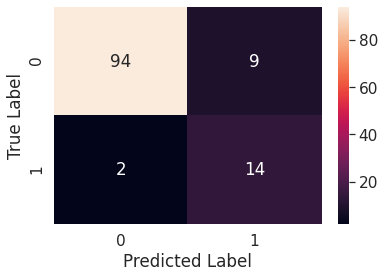

In [50]:
conf_matrix = tf.math.confusion_matrix(yftest, res).numpy()

df_cm = pd.DataFrame(conf_matrix, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, fmt="d") # font size
plt.xlabel("Predicted Label") 
plt.ylabel("True Label") 

plt.show()

In [51]:
f1_score_tf = 2 * (result["precision"] * result["recall"]) / (result["precision"] + result["recall"])

print("The Recall Score for our model is {}".format(result["recall"]))
print("The Precision Score for our model is {}".format(result["precision"]))

print("The F1 Score for our model is {}".format(f1_score_tf))

The Recall Score for our model is 0.875
The Precision Score for our model is 0.6086956262588501
The F1 Score for our model is 0.7179487200088767


### Try to Undersample the Data

In [52]:
#Undersampling the Majority Class

undersampler = RandomUnderSampler(random_state=42)

# fit and apply the transform
dftrain_under, yftrain_under = undersampler.fit_resample(dftrain_pure, yftrain_pure)

dftrain_under = pd.DataFrame(dftrain_under, columns=['M/F', 'Age', 'Educ', 'SES', 'MMSE'])
dftrain_under[['M/F','Educ','SES']] = dftrain_under[['M/F','Educ','SES']].astype(int)

yftrain_under = pd.DataFrame(yftrain_under, columns=['CDR'])

pd.concat([dftrain_under, yftrain_under]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 0 to 115
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     116 non-null    float64
 1   Age     116 non-null    float64
 2   Educ    116 non-null    float64
 3   SES     116 non-null    float64
 4   MMSE    116 non-null    float64
 5   CDR     116 non-null    float64
dtypes: float64(6)
memory usage: 12.7 KB


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CDR
1.0    58
0.0    58
dtype: int64


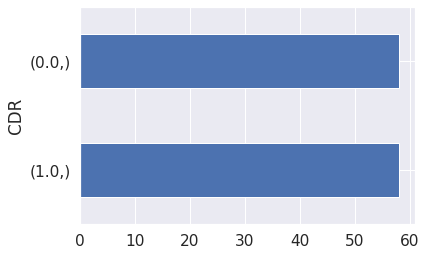

In [53]:
yftrain_under.value_counts().plot(kind='barh')
print(yftrain_under.value_counts())

In [54]:
#Dataset Preparation
CATEGORICAL_COLUMNS = ['M/F', 'Educ', 'SES']
NUMERIC_COLUMNS = ['MMSE', 'Age']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain_under[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

for value in feature_columns:
  if not hasattr(value, 'shape'):
    print("The {} column have {} as unique value with {} data type".format(value.key,value.vocabulary_list, value.dtype))
  else:
    print("The {} column have {} shape with {} data type".format(value.key,value.shape, value.dtype))

The M/F column have (1, 0) as unique value with <dtype: 'int64'> data type
The Educ column have (4, 3, 5, 2, 1) as unique value with <dtype: 'int64'> data type
The SES column have (3, 2, 4, 1, 5) as unique value with <dtype: 'int64'> data type
The MMSE column have (1,) shape with <dtype: 'float32'> data type
The Age column have (1,) shape with <dtype: 'float32'> data type


In [55]:
train_input_fn = make_input_fn(dftrain_under, yftrain_under)
eval_input_fn = make_input_fn(dftest, yftest, num_epochs=1, shuffle=False)

In [56]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.45378152, 'accuracy_baseline': 0.8655462, 'auc': 0.9086772, 'auc_precision_recall': 0.5338969, 'average_loss': 0.9521306, 'label/mean': 0.13445379, 'loss': 0.9562053, 'precision': 0.19753087, 'prediction/mean': 0.598816, 'recall': 1.0, 'global_step': 120}


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbg_2aett/model.ckpt-120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


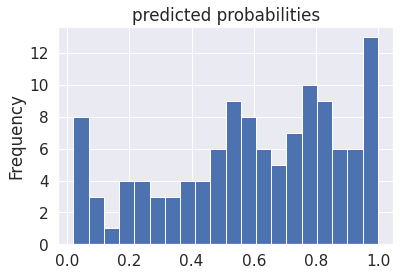

In [57]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0.0, 1.05)

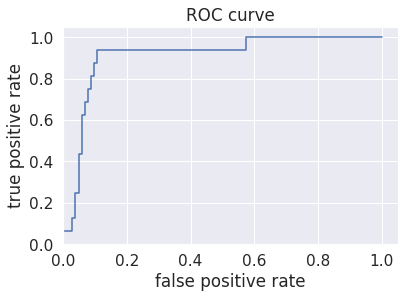

In [58]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(yftest, probs)

plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)

In [59]:
res = pd.Series([pred['class_ids'][0] for pred in pred_dicts])
res

0      0
1      1
2      1
3      1
4      1
      ..
114    1
115    1
116    1
117    0
118    1
Length: 119, dtype: int64

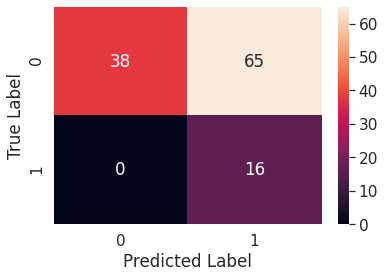

In [60]:
conf_matrix = tf.math.confusion_matrix(yftest, res).numpy()

df_cm = pd.DataFrame(conf_matrix, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, fmt="d") # font size
plt.xlabel("Predicted Label") 
plt.ylabel("True Label") 

plt.show()

In [61]:
f1_score_tf = 2 * (result["precision"] * result["recall"]) / (result["precision"] + result["recall"])

print("The Recall Score for our model is {}".format(result["recall"]))
print("The Precision Score for our model is {}".format(result["precision"]))

print("The F1 Score for our model is {}".format(f1_score_tf))

The Recall Score for our model is 1.0
The Precision Score for our model is 0.1975308656692505
The F1 Score for our model is 0.3298969092689877


### Generate Synthetic dataset with SMOTE

In [62]:
#Creating Synthetic Dataset

smote = SMOTE(random_state=29, sampling_strategy=0.8)

# fit and apply the transform
dftrain_smote, yftrain_smote = smote.fit_resample(dftrain_pure, yftrain_pure)

dftrain_smote = pd.DataFrame(dftrain_smote, columns=['M/F', 'Age', 'Educ', 'SES', 'MMSE'])
dftrain_smote[['M/F','Educ','SES']] = dftrain_smote[['M/F','Educ','SES']].astype(int)

yftrain_smote = pd.DataFrame(yftrain_smote, columns=['CDR'])

pd.concat([dftrain_smote, yftrain_smote]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1504 entries, 0 to 751
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     752 non-null    float64
 1   Age     752 non-null    float64
 2   Educ    752 non-null    float64
 3   SES     752 non-null    float64
 4   MMSE    752 non-null    float64
 5   CDR     752 non-null    float64
dtypes: float64(6)
memory usage: 82.2 KB


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CDR
0.0    418
1.0    334
dtype: int64


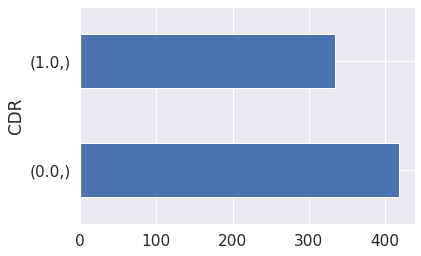

In [63]:
yftrain_smote.value_counts().plot(kind='barh')
print(yftrain_smote.value_counts())

In [64]:
#Dataset Preparation
CATEGORICAL_COLUMNS = ['M/F', 'Educ', 'SES']
NUMERIC_COLUMNS = ['MMSE', 'Age']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain_smote[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

for value in feature_columns:
  if not hasattr(value, 'shape'):
    print("The {} column have {} as unique value with {} data type".format(value.key,value.vocabulary_list, value.dtype))
  else:
    print("The {} column have {} shape with {} data type".format(value.key,value.shape, value.dtype))

The M/F column have (0, 1) as unique value with <dtype: 'int64'> data type
The Educ column have (3, 4, 5, 2, 1) as unique value with <dtype: 'int64'> data type
The SES column have (3, 1, 2, 4, 5) as unique value with <dtype: 'int64'> data type
The MMSE column have (1,) shape with <dtype: 'float32'> data type
The Age column have (1,) shape with <dtype: 'float32'> data type


In [65]:
train_input_fn = make_input_fn(dftrain_smote, yftrain_smote)
eval_input_fn = make_input_fn(dftest, yftest, num_epochs=1, shuffle=False)

In [66]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.8907563, 'accuracy_baseline': 0.8655462, 'auc': 0.93992716, 'auc_precision_recall': 0.647802, 'average_loss': 0.30413422, 'label/mean': 0.13445379, 'loss': 0.30441973, 'precision': 0.56, 'prediction/mean': 0.26083755, 'recall': 0.875, 'global_step': 760}


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpl0om8uwd/model.ckpt-760
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


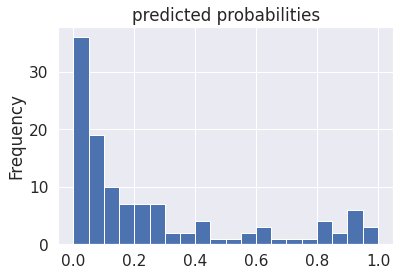

In [67]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [68]:
res = pd.Series([pred['class_ids'][0] for pred in pred_dicts])
res

0      0
1      0
2      0
3      0
4      0
      ..
114    0
115    0
116    0
117    0
118    0
Length: 119, dtype: int64

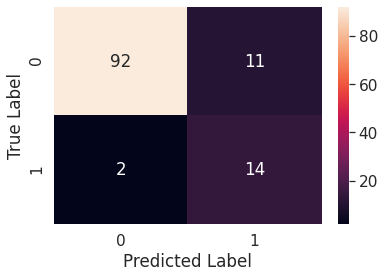

In [69]:
conf_matrix = tf.math.confusion_matrix(yftest, res).numpy()

df_cm = pd.DataFrame(conf_matrix, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, fmt="d") # font size
plt.xlabel("Predicted Label") 
plt.ylabel("True Label") 

plt.show()

In [70]:
f1_score_tf = 2 * (result["precision"] * result["recall"]) / (result["precision"] + result["recall"])

print("The Recall Score for our model is {}".format(result["recall"]))
print("The Precision Score for our model is {}".format(result["precision"]))

print("The F1 Score for our model is {}".format(f1_score_tf))

The Recall Score for our model is 0.875
The Precision Score for our model is 0.5600000023841858
The F1 Score for our model is 0.6829268697915507
